In [211]:
import math
import copy
import matplotlib.pyplot as plt
from dataclasses import dataclass
from functools import partial
from collections import OrderedDict
from prettytable import PrettyTable

import torch
import torchvision
from torch import nn, Tensor
from torchvision.ops import StochasticDepth
from torchvision.ops.misc import Conv2dNormActivation, SqueezeExcitation

from typing import Any, Callable, List, Optional, Sequence, Tuple, Union

### helper functions

In [4]:
def _make_divisible(v: float, divisor: int, min_value: Optional[int] = None) -> int:
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def count_parameters(model, showTable=False):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    if showTable:
        print(table)
    return total_params


def calculate_storage(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    print(f"Buffer size: {buffer_size/1024**2:.3f} MB")

    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

### MBConv Block

In [5]:
class MBConv(nn.Module):
    def __init__(
        self,
        cfg,
        stochastic_depth_prob: float,
        norm_layer: Callable[..., nn.Module],
        se_layer: Optional[Callable[..., nn.Module]] = SqueezeExcitation,
        conv_layer: Optional[Callable[..., nn.Module]] = Conv2dNormActivation,
    ) -> None:
        super().__init__()

        if not (1 <= cfg.stride <= 2):
            raise ValueError("illegal stride value")

        self.use_res_connect = (
            cfg.stride == 1 and cfg.input_channels == cfg.out_channels
        )

        layers: List[nn.Module] = []
        activation_layer = nn.SiLU

        # expand
        expanded_channels = cfg.adjust_channels(cfg.input_channels, cfg.expand_ratio)
        if expanded_channels != cfg.input_channels:
            layers.append(
                Conv2dNormActivation(
                    cfg.input_channels,
                    expanded_channels,
                    kernel_size=1,
                    norm_layer=norm_layer,
                    activation_layer=activation_layer,
                )
            )

        # depthwise
        layers.append(
            conv_layer(
                expanded_channels,
                expanded_channels,
                kernel_size=cfg.kernel,
                stride=cfg.stride,
                groups=expanded_channels,
                norm_layer=norm_layer,
                activation_layer=activation_layer,
            )
        )
        if se_layer is not None:
            # squeeze and excitation
            squeeze_channels = max(1, cfg.input_channels // 4)
            layers.append(
                se_layer(
                    expanded_channels,
                    squeeze_channels,
                    activation=partial(nn.SiLU, inplace=True),
                )
            )

        # project
        layers.append(
            Conv2dNormActivation(
                expanded_channels,
                cfg.out_channels,
                kernel_size=1,
                norm_layer=norm_layer,
                activation_layer=None,
            )
        )

        self.block = nn.Sequential(*layers)
        if stochastic_depth_prob > 0.0:
            self.stochastic_depth = StochasticDepth(stochastic_depth_prob, "row")
        self.out_channels = cfg.out_channels

    def forward(self, input: Tensor) -> Tensor:
        result = self.block(input)
        if self.use_res_connect:
            result = self.stochastic_depth(result)
            result += input
        return result

### MBConv configuration

In [6]:
@dataclass
class _MBConvConfig:
    expand_ratio: float
    kernel: int
    stride: int
    input_channels: int
    out_channels: int
    num_layers: int
    dropout_p: float 
    use_skip: bool # skip connection between encoder and decoder
    block: Callable[..., nn.Module]

    @staticmethod
    def adjust_channels(
        channels: int, width_mult: float, min_value: Optional[int] = None
    ) -> int:
        return _make_divisible(channels * width_mult, 8, min_value)

    @staticmethod
    def adjust_depth(num_layers: int, depth_mult: float):
        return int(math.ceil(num_layers * depth_mult))


class MBConvConfig(_MBConvConfig):
    # Stores information listed at Table 1 of the EfficientNet paper
    def __init__(
        self,
        expand_ratio: float,
        kernel: int,
        stride: int,
        input_channels: int,
        out_channels: int,
        num_layers: int,
        dropout_p: float,
        use_skip: bool,
        width_mult: float = 1.0,
        depth_mult: float = 1.0,
        block: Optional[Callable[..., nn.Module]] = MBConv,
    ) -> None:
        input_channels = self.adjust_channels(input_channels, width_mult)
        out_channels = self.adjust_channels(out_channels, width_mult)
        num_layers = self.adjust_depth(num_layers, depth_mult)
        super().__init__(
            expand_ratio,
            kernel,
            stride,
            input_channels,
            out_channels,
            num_layers,
            dropout_p,
            use_skip,
            block,
        )

### EfficientNet Config

In [41]:
def _efficientnet_cfg(width_mult: float, depth_mult: float) -> Sequence[MBConvConfig]:
    inverted_residual_setting = Sequence[MBConvConfig]

    bneck_conf = partial(MBConvConfig, width_mult=width_mult, depth_mult=depth_mult)
    inverted_residual_setting = [
        #         t, k, s, in, out, n, p, skip
        bneck_conf(1, 3, 1, 32, 16, 1, 0, 1),
        bneck_conf(6, 3, 2, 16, 24, 2, 0, 1),
        bneck_conf(6, 5, 2, 24, 40, 2, 0, 1),
        bneck_conf(6, 3, 2, 40, 80, 3, 0, 0),
        bneck_conf(6, 5, 1, 80, 112, 3, 0.5, 1),
        bneck_conf(6, 5, 2, 112, 192, 4, 0.5, 0),
        bneck_conf(6, 3, 1, 192, 320, 1, 0.5, 0),
    ]

    return inverted_residual_setting

In [8]:
efficient_nets = {
    'efficientnet-b0': (1.0, 1.0, 224, 0.2),
    'efficientnet-b1': (1.0, 1.1, 240, 0.2),
    'efficientnet-b2': (1.1, 1.2, 260, 0.3),
    'efficientnet-b3': (1.2, 1.4, 300, 0.3),
    'efficientnet-b4': (1.4, 1.8, 380, 0.4),
    'efficientnet-b5': (1.6, 2.2, 456, 0.4),
    'efficientnet-b6': (1.8, 2.6, 528, 0.5),
    'efficientnet-b7': (2.0, 3.1, 600, 0.5),
}

### EfficientNet

In [42]:
class EfficientNet(nn.Module):
    def __init__(
        self,
        inverted_residual_setting: Sequence[MBConvConfig],
        stochastic_depth_prob: float = 0.2,
        num_classes: int = 1000,
        norm_layer: Optional[Callable[..., nn.Module]] = nn.BatchNorm2d,
        activation_layer: Optional[Callable[..., nn.Module]] = nn.SiLU,
        dropout_layer: Optional[Callable[..., nn.Module]] = nn.Dropout2d,
        last_channel: Optional[int] = None,
    ) -> None:
        super().__init__()

        self.inv_res_setting = inverted_residual_setting

        encoder: OrderedDict[str, nn.Module] = OrderedDict()

        # build first conv layer
        firstconv_output_channels = self.inv_res_setting[0].input_channels
        encoder["conv0"] = Conv2dNormActivation(
            3,
            firstconv_output_channels,
            kernel_size=3,
            stride=2,
            norm_layer=norm_layer,
            activation_layer=activation_layer,
        )

        # build inverted residual blocks
        total_stage_blocks = sum(cfg.num_layers for cfg in self.inv_res_setting)
        stage_block_id = 0
        for i, cfg in enumerate(self.inv_res_setting):
            stage: List[nn.Module] = []
            for j in range(cfg.num_layers):
                # copy to avoid modifications. shallow copy is enough
                block_cfg = copy.copy(cfg)

                # overwrite info if not the first conv in the stage
                if stage:
                    block_cfg.input_channels = block_cfg.out_channels
                    block_cfg.stride = 1

                # adjust stochastic depth probability based on the depth of the stage block
                sd_prob = (
                    stochastic_depth_prob * float(stage_block_id) / total_stage_blocks
                )

                stage.append(block_cfg.block(block_cfg, sd_prob, norm_layer))
                stage_block_id += 1

            if cfg.dropout_p > 0:
                stage.append(dropout_layer(cfg.dropout_p))

            encoder[f"stage{i+1}"] = nn.Sequential(*stage)

        # building last several layers
        lastconv_input_channels = self.inv_res_setting[-1].out_channels
        lastconv_output_channels = (
            last_channel if last_channel is not None else 4 * lastconv_input_channels
        )
        encoder["lastConv"] = Conv2dNormActivation(
            lastconv_input_channels,
            lastconv_output_channels,
            kernel_size=1,
            norm_layer=norm_layer,
            activation_layer=nn.SiLU,
        )
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(lastconv_output_channels, num_classes),
        )

        # ========= weight initialization ========
        self.encoder = nn.Sequential(encoder)

        self._init_weights()

    def forward(self, x: Tensor) -> Tensor:
        features = []

        # first conv
        x = self.encoder.conv0(x)
        print(f"First conv: {x.shape}")

        # stages
        for i, cfg in enumerate(self.inv_res_setting):
            x = self.encoder[i + 1](x)
            print(f"Stage{i+1}: {x.shape}")
            if cfg.use_skip:
                features.append(x)
                print("use Skip")

        # last conv
        x = self.encoder.lastConv(x)
        print(f"Last conv: {x.shape}")
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x

    def _init_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

### Forward pass

In [43]:
net_name = "efficientnet-b0"
width_mult = efficient_nets[net_name][0]
depth_mult = efficient_nets[net_name][1]
d = efficient_nets[net_name][2]

setting = _efficientnet_cfg(width_mult=width_mult, depth_mult=depth_mult)

net = EfficientNet(setting)

# test forward pass
x_batch = torch.zeros(1, 3, d, d)
print(f"input dimension: {x_batch.shape}")
print(f"output dimension: {net(x_batch).shape}")

size_all_mb = calculate_storage(net)
print("model size: {:.3f} MB".format(size_all_mb))  # 20.335 MB

total_params = count_parameters(net, False)
print(f"Total Trainable Params: {total_params}")  # 5288548

input dimension: torch.Size([1, 3, 224, 224])
First conv: torch.Size([1, 32, 112, 112])
Stage1: torch.Size([1, 16, 112, 112])
use Skip
Stage2: torch.Size([1, 24, 56, 56])
use Skip
Stage3: torch.Size([1, 40, 28, 28])
use Skip
Stage4: torch.Size([1, 80, 14, 14])
Stage5: torch.Size([1, 112, 14, 14])
use Skip
Stage6: torch.Size([1, 192, 7, 7])
Stage7: torch.Size([1, 320, 7, 7])
Last conv: torch.Size([1, 1280, 7, 7])
output dimension: torch.Size([1, 1000])
Buffer size: 0.161 MB
model size: 20.335 MB
Total Trainable Params: 5288548


In [11]:
# mobilenet_v2_pretrained = torchvision.models.mobilenet_v2()
net_pretrained = torchvision.models.efficientnet_b0()

size_all_mb = calculate_storage(net_pretrained)
print("model size: {:.3f} MB".format(size_all_mb))  # 13.501 MB

total_params = count_parameters(net_pretrained, False)
print(f"Total Trainable Params: {total_params}")  # 3504872

Buffer size: 0.161 MB
model size: 20.335 MB
Total Trainable Params: 5288548


## Build UNet with EfficientNet

### Deconv2dNormActivation

In [120]:
class Deconv2dNormActivation(nn.Sequential):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[int, Tuple[int, ...]] = 3,
        stride: Union[int, Tuple[int, ...]] = 1,
        padding: Optional[Union[int, Tuple[int, ...], str]] = None,
        out_pad: Optional[Union[int, Tuple[int, ...]]] = None,
        groups: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = nn.BatchNorm2d,
        activation_layer: Optional[Callable[..., nn.Module]] = nn.ReLU,
        inplace: Optional[bool] = True,
        dilation: Union[int, Tuple[int, ...]] = 1,
        bias: Optional[bool] = None,
        conv_layer: Callable[..., nn.Module] = nn.ConvTranspose2d,
    ) -> None:
        # calculate padding
        if padding is None:
            if dilation > 1:
                padding = dilation * (kernel_size - 1) // 2
            else:
                padding = kernel_size // 2
        # calculate output padding
        if out_pad is None:
            if stride == 2:
                out_pad = 1
            else:
                out_pad = 0

        layers = [
            conv_layer(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                out_pad,
                dilation=dilation,
                groups=groups,
                bias=bias,
            )
        ]

        if norm_layer is not None:
            layers.append(norm_layer(out_channels))

        if activation_layer is not None:
            params = {} if inplace is None else {"inplace": inplace}
            layers.append(activation_layer(**params))

        super().__init__(*layers)

        self.out_channels = out_channels

### UNet

Encoder: EfficientNet, parameterised by MBConvConfig
Decoder: Symmetrical blocks, only difference is replacing conv2d with TransposeConv2d

Skip connections: indicated in MBConvConfig

In [209]:
class UNet(nn.Module):
    def __init__(
        self,
        inverted_residual_setting: Sequence[MBConvConfig],
        input_width: int = 224,
        stochastic_depth_prob: float = 0.2,
        num_classes: int = 1000,
        norm_layer: Optional[Callable[..., nn.Module]] = nn.BatchNorm2d,
        activation_layer: Optional[Callable[..., nn.Module]] = nn.SiLU,
        dropout_layer: Optional[Callable[..., nn.Module]] = nn.Dropout2d,
        last_channel: Optional[int] = None,
    ) -> None:
        super().__init__()

        self.inv_res_setting = inverted_residual_setting
        self.stochastic_depth_prob = stochastic_depth_prob
        self.num_classes = num_classes
        self.norm_layer = norm_layer
        self.activation_layer = activation_layer
        self.dropout_layer = dropout_layer
        self.input_width = input_width
        self.last_channel = last_channel or self.inv_res_setting[-1].out_channels * 4

        self.decoder_config = self._decoder_config()

        # return

        # ========= Build blocks ==========
        encoder: OrderedDict = self._build_encoder()
        decoder: OrderedDict = self._build_decoder()
        self.encoder = nn.Sequential(encoder)
        self.decoder = nn.Sequential(decoder)
        self.softmax = nn.Softmax(dim=1)

        # ========= weight initialization ========
        self._init_weights()

    def forward(self, x: Tensor) -> Tensor:
        features = []

        # ================= Encoder =================
        # first conv
        x = self.encoder.conv0(x)

        # stages
        for i, cfg in enumerate(self.inv_res_setting):
            x = self.encoder[i + 1](x)
            if cfg.use_skip:
                features.append(x)

        # last conv
        x = self.encoder.lastConv(x)

        # ================= Decoder =================
        # first deconv
        x = self.decoder.deconv0(x)

        # stages
        for i, cfg in enumerate(self.decoder_config):
            x = self.decoder[i + 1](x)
            if i < len(self.decoder_config) - 1 and self.decoder_config[i + 1].use_skip:
                x = torch.cat([x, features.pop()], dim=1)

        # last deconv
        x = self.decoder.lastDeconv(x)
        x = self.softmax(x)

        return x

    def _decoder_config(self) -> List[MBConvConfig]:
        decoder_cfg: List[MBConvConfig] = []
        oup = self.inv_res_setting[0].input_channels
        skip = 0
        for cfg in self.inv_res_setting:
            skip = cfg.out_channels if cfg.use_skip else 0
            cfg_copy = copy.copy(cfg)
            cfg_copy.input_channels = cfg.out_channels + skip
            cfg_copy.out_channels = oup
            decoder_cfg.append(cfg_copy)

            oup = cfg.out_channels

        return decoder_cfg[::-1]

    def _build_decoder(self) -> OrderedDict:
        decoder: OrderedDict[str, nn.Module] = OrderedDict()

        out = self.inv_res_setting[-1].out_channels
        decoder["deconv0"] = Conv2dNormActivation(
            self.last_channel, out, 1, 1, bias=False
        )

        def compute_out_pad(stage: int, dim: int) -> int:
            dim = math.ceil(dim / 2)  # account for first encoder
            # reverse the order to calculate output dim for corresponding encoder
            stage = len(self.inv_res_setting) - stage - 1
            for cfg in self.inv_res_setting[:stage]:
                if cfg.stride != 1:
                    # reduce dim if stride is not 1
                    dim = math.ceil(dim / 2)
            return int(dim % 2 == 0)

        # build inverted residual blocks
        total_stage_blocks = sum(cfg.num_layers for cfg in self.inv_res_setting)
        stage_block_id = 0
        for i, cfg in enumerate(self.decoder_config):
            stage: List[nn.Module] = []
            for j in range(cfg.num_layers):
                # copy to avoid modifications. shallow copy is enough
                block_cfg = copy.copy(cfg)

                conv_layer = Conv2dNormActivation
                if block_cfg.stride != 1 and j == 0:
                    oup_pad = compute_out_pad(i, self.input_width)
                    conv_layer = partial(
                        Deconv2dNormActivation,
                        out_pad=oup_pad,
                    )
                # overwrite cfg if not first conv in the stage
                if j != 0:
                    block_cfg.input_channels = block_cfg.out_channels
                    block_cfg.stride = 1

                # adjust stochastic depth probability
                sd_prob = (
                    self.stochastic_depth_prob
                    * float(stage_block_id)
                    / total_stage_blocks
                )

                stage.append(
                    block_cfg.block(
                        block_cfg,
                        sd_prob,
                        self.norm_layer,
                        conv_layer=conv_layer,
                    )
                )
                stage_block_id += 1

            if cfg.dropout_p > 0:
                stage.append(self.dropout_layer(cfg.dropout_p))

            decoder[f"stage{i+1}"] = nn.Sequential(*stage)

        # build last deconv
        decoder["lastDeconv"] = Deconv2dNormActivation(
            self.decoder_config[-1].out_channels,
            self.num_classes,
            kernel_size=3,
            stride=2,
            padding=1,
            norm_layer=self.norm_layer,
            activation_layer=self.activation_layer,
        )
        return decoder

    def _build_encoder(self) -> OrderedDict:
        encoder: OrderedDict[str, nn.Module] = OrderedDict()

        # build first conv layer
        firstconv_output_channels = self.inv_res_setting[0].input_channels
        encoder["conv0"] = Conv2dNormActivation(
            3,
            firstconv_output_channels,
            kernel_size=3,
            stride=2,
            norm_layer=self.norm_layer,
            activation_layer=self.activation_layer,
        )

        # build inverted residual blocks
        total_stage_blocks = sum(cfg.num_layers for cfg in self.inv_res_setting)
        stage_block_id = 0
        for i, cfg in enumerate(self.inv_res_setting):
            stage: List[nn.Module] = []
            for j in range(cfg.num_layers):
                # copy to avoid modifications. shallow copy is enough
                block_cfg = copy.copy(cfg)

                # overwrite info if not the first conv in the stage
                if stage:
                    block_cfg.input_channels = block_cfg.out_channels
                    block_cfg.stride = 1

                # adjust stochastic depth probability based on the depth of the stage block
                sd_prob = (
                    self.stochastic_depth_prob
                    * float(stage_block_id)
                    / total_stage_blocks
                )

                stage.append(block_cfg.block(block_cfg, sd_prob, self.norm_layer))
                stage_block_id += 1

            if cfg.dropout_p > 0:
                stage.append(self.dropout_layer(cfg.dropout_p))

            encoder[f"stage{i+1}"] = nn.Sequential(*stage)

        # build last several layers
        lastconv_input_channels = self.inv_res_setting[-1].out_channels
        lastconv_output_channels = self.last_channel
        encoder["lastConv"] = Conv2dNormActivation(
            lastconv_input_channels,
            lastconv_output_channels,
            kernel_size=1,
            norm_layer=self.norm_layer,
            activation_layer=nn.SiLU,
        )
        return encoder

    def _init_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

### Debug 

input dimension: torch.Size([1, 3, 224, 224])
output dimension: torch.Size([1, 3, 224, 224])


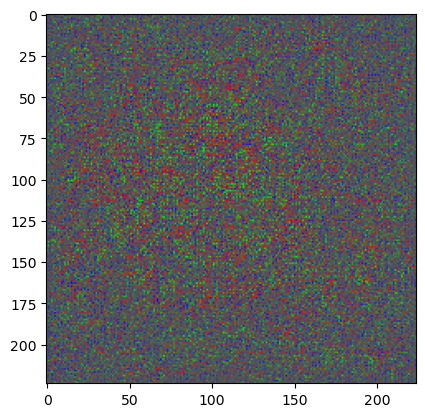

In [218]:
net_name = "efficientnet-b0"
width_mult = efficient_nets[net_name][0]
depth_mult = efficient_nets[net_name][1]
d = efficient_nets[net_name][2]

setting = _efficientnet_cfg(width_mult=width_mult, depth_mult=depth_mult)

net = UNet(setting, input_width=d, num_classes=3)

x_batch = torch.randn(1, 3, d, d)
out = net(x_batch)
print(f"input dimension: {x_batch.shape}")
print(f"output dimension: {out.shape}")

plt.imshow(out[0, :, :, :].permute(1, 2, 0).detach().numpy())

In [208]:
print("----ENCODER----")
size_all_mb = calculate_storage(net.encoder)
print("model size: {:.3f}MB".format(size_all_mb))
total_params = count_parameters(net.encoder)
print(f"Total Trainable Params: {total_params}")


print("----DECODER----")
size_all_mb = calculate_storage(net.decoder)
print("model size: {:.3f}MB".format(size_all_mb))
total_params = count_parameters(net.decoder)
print(f"Total Trainable Params: {total_params}")


print("----UNET----")
size_all_mb = calculate_storage(net)
print("model size: {:.3f}MB".format(size_all_mb))
total_params = count_parameters(net)
print(f"Total Trainable Params: {total_params}")

----ENCODER----
Buffer size: 0.161 MB
model size: 15.448MB
Total Trainable Params: 4007548
----DECODER----
Buffer size: 0.154 MB
model size: 15.194MB
Total Trainable Params: 3942596
----UNET----
Buffer size: 0.315 MB
model size: 30.642MB
Total Trainable Params: 7950144
